# Using PTFA package
This notebook provides a testing ground for the `ptfa` package. It provides functions used to generate synthetic data according to a variety of generating processes (DGPs). Our `ptfa` package provides routines to recover factors and loadings given the assumed DGP, and examples are divided accordingly allowing for easy comparison across methods and settings.

In [67]:
# Import necessary packages used throughout session
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Import updated PTFA package and PLS for comparison
import ptfa
from sklearn.cross_decomposition import PLSRegression

# Handy function to construct pretty ranges for plotting
def variable_plot_range(x, percentage = 0.05):
    min_value = np.min(x)
    max_value = np.max(x)
    range_value = max_value - min_value
    adjustment = percentage * range_value
    return (min_value - adjustment, max_value + adjustment)

## Standard specification
The standard and simpliest specification of the Probabilistic Targeted Factor Model (PTFA) is
$$
\begin{align*}
    X & = FP' + E_x \\
    Y & = FQ' + E_y
\end{align*}
$$
where $X$ is a $T \times p$ matrix of features, $Y$ is a $T \times q$ matrix of target variables of interest, $F$ is a $T \times k$ matrix of factors or scores, $P$ is the $p \times k$ matrix of loadings in the feature equation, and $Q$ is the $q \times k$ matrix of loadings in the target equation. It assumed that the co-movements in $X$ and $Y$ are driven by a set of low-dimensional factors such that $k \ll p$. $E_X$ is a $T \times p$ matrix of disturbances with each element distributed according to $\text{Normal}(0, \sigma_x^2)$ and $E_Y$ is a $T \times q$ matrix of disturbances with each element distributed according to $\text{Normal}(0, \sigma_y^2)$. $E_X$ and $E_Y$ are assumed uncorrelated throughout all examples. We generate variables using a prior variance $V_F = I_k$, an identity of order $k$.

In [68]:
# Simulation control parameters
T, p, q, k, h = 200, 10, 1, 2, 1
true_sigma_x, true_sigma_y = 1.0, 1.0
seed_value = 12345
rng = np.random.default_rng(seed_value)

# Generate synthetic data using the provided function
X, Y, F, P_true, Q_true = ptfa.generation.generate_data_simple(T, p, q, k, true_sigma_x, true_sigma_y, rng)
X = (X - X.mean(axis = 0)) / X.std(axis = 0)
Y = (Y - Y.mean(axis = 0)) / Y.std(axis = 0)

# Generate synthetic predictors for forecasting
X_pred = rng.normal(size = [h, p])

# Apply PLS regression
pls = PLSRegression(n_components=k)
pls.fit(X, Y)
Y_fitted_pls_simple = pls.predict(X)

# Apply our PTFA EM method
ptfa_simple = ptfa.ProbabilisticTFA(n_components=k)
ptfa_simple.fit(X, Y, standardize=False)
Y_fitted_ptfa_simple = ptfa_simple.fitted()

# Out-of-sample prediction using both methods
Y_pred_pls_simple = pls.predict(X_pred)
Y_pred_ptfa_simple, Y_variance_ptfa_simple = ptfa_simple.predict(X_pred, compute_variance = True)

# Compute R-squared for both models and compare them
r2_pls_simple = r2_score(Y, Y_fitted_pls_simple, multioutput = "raw_values")
r2_ptfa_simple = r2_score(Y, Y_fitted_ptfa_simple, multioutput = "raw_values")
r2_results = {"R^2 PLS": r2_pls_simple, "R^2 Probabilistic PLS": r2_ptfa_simple}
print(r2_results)

# Obtain predicted confidence intervals for the prediction of Y using PTFA
Y_se_ptfa_simple = np.sqrt(np.diag(Y_variance_ptfa_simple))
CI_bounds = np.outer([-1, 1], 1.96 * Y_se_ptfa_simple)
CI_ptfa_simple = np.stack([Y_pred_ptfa_simple + CI_bounds[0], Y_pred_ptfa_simple + CI_bounds[1]])
print(CI_ptfa_simple)

{'R^2 PLS': array([0.77889468]), 'R^2 Probabilistic PLS': array([0.91098275])}
[[[-0.99853713]]

 [[ 0.86677668]]]


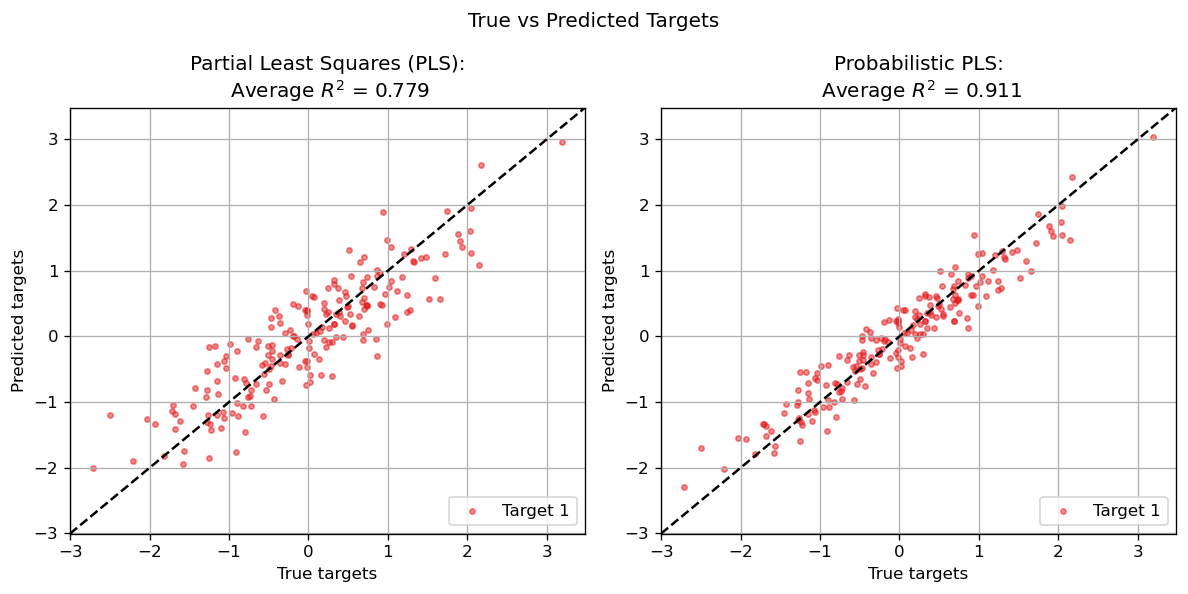

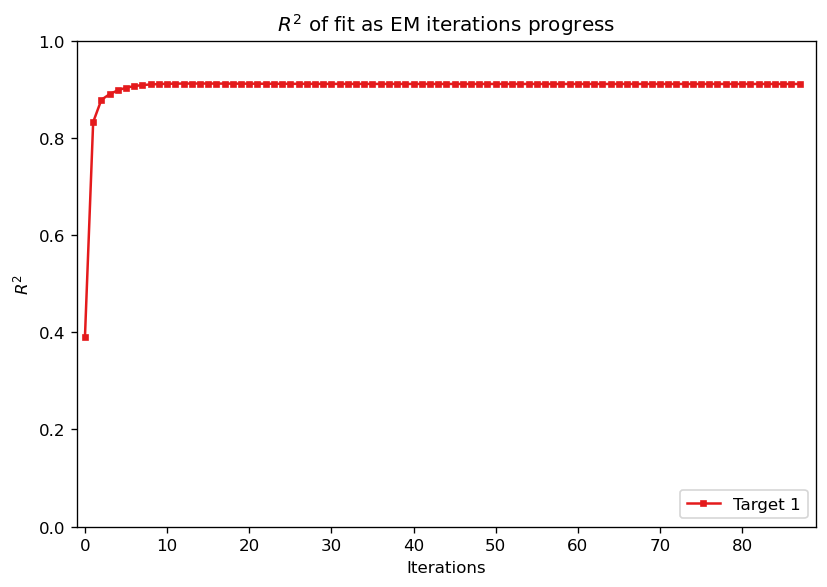

In [69]:
# Visualize comparison between methods
all_range = variable_plot_range([Y, Y_fitted_pls_simple, Y_fitted_ptfa_simple])
axis_range = [*all_range, *all_range]
colors = plt.colormaps["Set1"]
names = ["Target " + str(i+1) for i in range(q)]

# Visualization of true vs. tredicted responses
plt.figure(figsize=(10, 5), dpi=120)
plt.suptitle("True vs Predicted Targets")

# PLS regression
plt.subplot(1, 2, 1)
for i in range(q):
    plt.scatter(Y[:, i], Y_fitted_pls_simple[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
plt.plot(all_range, all_range, "k--")
plt.axis(axis_range)
plt.title(f'Partial Least Squares (PLS):\n Average $R^2$ = {np.mean(r2_pls_simple):.3f}')
plt.xlabel('True targets')
plt.ylabel('Predicted targets')
plt.legend(loc="lower right")
plt.grid(True)

# Probabilistic PLS (Without standardization)
plt.subplot(1, 2, 2)
for i in range(q):
    plt.scatter(Y[:, i], Y_fitted_ptfa_simple[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
plt.plot(all_range, all_range, "k--")
plt.axis(axis_range)
plt.title(f'Probabilistic PLS:\n Average $R^2$ = {np.mean(r2_ptfa_simple):.3f}')
plt.xlabel('True targets')
plt.ylabel('Predicted targets')
plt.legend(loc="lower right")
plt.grid(True)

# Show resulting plot
plt.tight_layout()
plt.show()

# Plot path of R-squared in PTFA
max_iterations = ptfa_simple.r2_array.shape[0]
plt.figure(figsize=(7, 5), dpi=120)
plt.title("$R^2$ of fit as EM iterations progress")
for i in range(q):
    plt.plot(ptfa_simple.r2_array[:, i], "s-", color=colors(i), label=names[i], markersize=3)
plt.axis([-1, max_iterations+1, 0, 1])
plt.xlabel("Iterations")
plt.ylabel("$R^2$")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## System covariance
The paper shows that the recovery of factors and loadings is robust to the covariance process of the features and targets as long as the data is standardized prior to processing. By allowing more complicated processes for $E_X$ and $E_Y$, we can test the robustness of our framework to misspecified data-generating processes. This example shows that the PTFA setup does not assume independent errors as a correct distributional assumption, but rather uses this framework to provide probabilistic targeted factor extraction.

Let $E_{X, t}$ and $E_{Y, t}$ represent an arbitrary row of $E_X$ and $E_Y$, respectively. We can allow for $E_{X, t} \sim \text{Normal}(0_p, \Sigma_X)$ and $E_{Y, t} \sim \text{Normal}(0_q, \Sigma_Y)$ for general covariance matrices $\Sigma_X$ and $\Sigma_Y$. We provide functions that generate $X$ and $Y$ assuming $\Sigma_X$ and $\Sigma_Y$ have the following generic Toeplitz structure:
$$
\Sigma_X = \begin{bmatrix} \sigma_{x, 1} & \sigma_{x, 2} & \cdots & \sigma_{x, p} \\ \sigma_{x, 2} & \sigma_{x, 1} & \cdots & \sigma_{x, p-1} \\ \vdots & \vdots & \ddots & \vdots \\ \sigma_{x, p} & \sigma_{x, p-1} & \cdots & \sigma_{x, 1} \end{bmatrix} \quad \text{and} \quad
\Sigma_Y = \begin{bmatrix} \sigma_{y, 1} & \sigma_{y, 2} & \cdots & \sigma_{y, q} \\ \sigma_{y, 2} & \sigma_{y, 1} & \cdots & \sigma_{y, q-1} \\ \vdots & \vdots & \ddots & \vdots \\ \sigma_{y, q} & \sigma_{y, q-1} & \cdots & \sigma_{y, 1} \end{bmatrix}
$$
for sequences $\sigma_{x} = (\sigma_{x, 1}, \ldots, \sigma_{x, p})$ and $\sigma_{y} = (\sigma_{y, 1}, \ldots, \sigma_{y, q})$. In our example, we set $\sigma_{x, j} = |\rho_x|^{j-1}$ for $j = 1, \ldots, p$ and $\sigma_{y, j} = |\rho_y|^{j-1}$ for $j = 1, \ldots, q$, given correlation parameters $\rho_x$ and $\rho_y$.

In [70]:
# Simulation control parameters
rho_x, rho_y = 0.5, 0.5
true_sigma_x = np.array([rho_x**j for j in range(p)])
true_sigma_y = np.array([rho_y**j for j in range(q)])

# Generate synthetic data using the provided function
X, Y, F, P_true, Q_true, Sigma_x, Sigma_y = ptfa.generation.generate_data_system(T, p, q, k, true_sigma_x, true_sigma_y, rng)
X = (X - X.mean(axis = 0)) / X.std(axis = 0)
Y = (Y - Y.mean(axis = 0)) / Y.std(axis = 0)

# Generate synthetic predictors for forecasting
X_pred = rng.normal(size = [h, p])

# Apply PLS regression
pls = PLSRegression(n_components=k)
pls.fit(X, Y)
Y_fitted_pls_system = pls.predict(X)

# Apply our PTFA EM method on standardized variables
ptfa_system = ptfa.ProbabilisticTFA(n_components=k)
ptfa_system.fit(X, Y, standardize=False, track_r2=True)
Y_fitted_ptfa_system = ptfa_system.fitted()

# Out-of-sample prediction using both methods
Y_pred_pls_system = pls.predict(X_pred)
Y_pred_ptfa_system, Y_variance_ptfa_system = ptfa_system.predict(X_pred, compute_variance=True)

# Compute R-squared for both models and compare them
r2_pls_system = r2_score(Y, Y_fitted_pls_system, multioutput = "raw_values")
r2_ptfa_system = r2_score(Y, Y_fitted_ptfa_system, multioutput = "raw_values")
r2_results = {"R^2 PLS": r2_pls_system, "R^2 Probabilistic PLS": r2_ptfa_system}
print(r2_results)

# Obtain predicted confidence intervals for the prediction of Y using PTFA
Y_se_ptfa_system = np.sqrt(np.diag(Y_variance_ptfa_system))
CI_bounds = np.outer([-1, 1], 1.96 * Y_se_ptfa_system)
CI_ptfa_system = np.stack([Y_pred_ptfa_system + CI_bounds[0], Y_pred_ptfa_system + CI_bounds[1]])
print(CI_ptfa_system)

{'R^2 PLS': array([0.67213318]), 'R^2 Probabilistic PLS': array([0.87522722])}
[[[-1.19413999]]

 [[ 1.14691844]]]


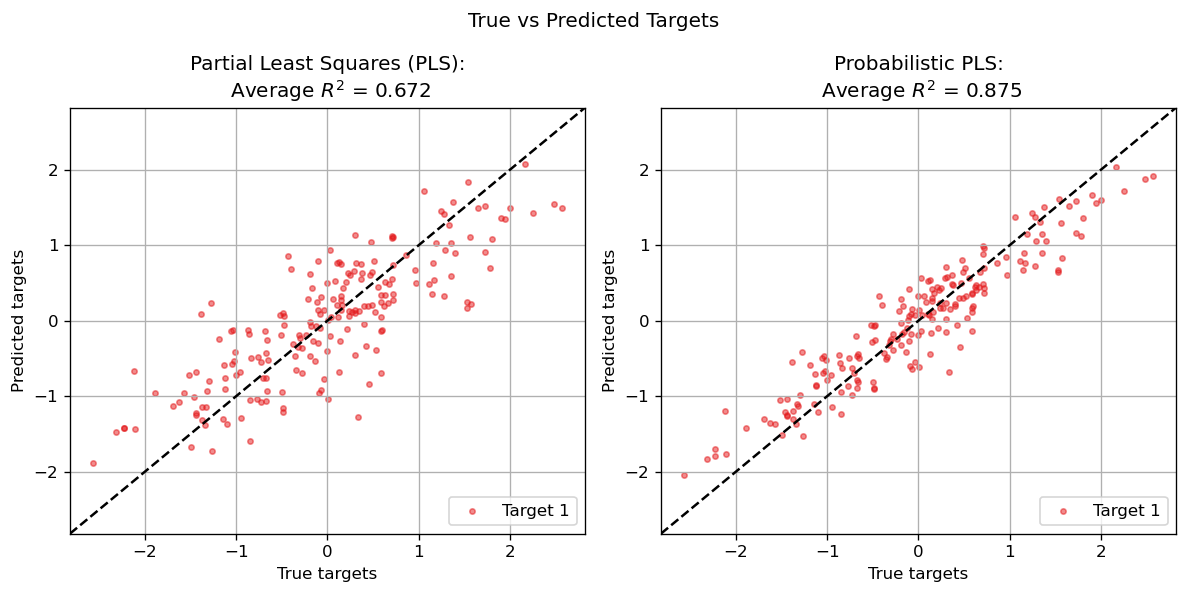

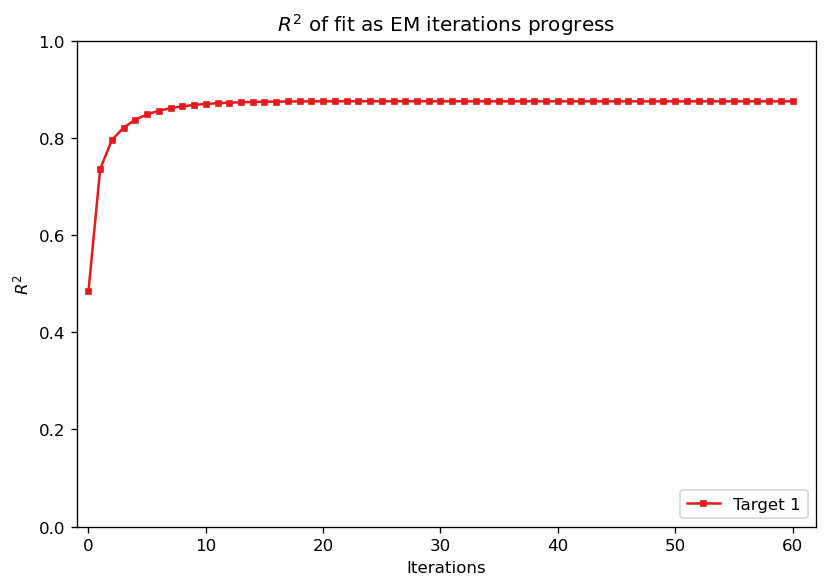

In [71]:
# Visualize comparison between methods
all_range = variable_plot_range([Y, Y_fitted_pls_system, Y_fitted_ptfa_system])
axis_range = [*all_range, *all_range]
colors = plt.colormaps["Set1"]
names = ["Target " + str(i+1) for i in range(q)]

# Visualization of true vs. tredicted responses
plt.figure(figsize=(10, 5), dpi=120)
plt.suptitle("True vs Predicted Targets")

# PLS regression
plt.subplot(1, 2, 1)
for i in range(q):
    plt.scatter(Y[:, i], Y_fitted_pls_system[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
plt.plot(all_range, all_range, "k--")
plt.axis(axis_range)
plt.title(f'Partial Least Squares (PLS):\n Average $R^2$ = {np.mean(r2_pls_system):.3f}')
plt.xlabel('True targets')
plt.ylabel('Predicted targets')
plt.legend(loc="lower right")
plt.grid(True)

# Probabilistic PLS (Without standardization)
plt.subplot(1, 2, 2)
for i in range(q):
    plt.scatter(Y[:, i], Y_fitted_ptfa_system[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
plt.plot(all_range, all_range, "k--")
plt.axis(axis_range)
plt.title(f'Probabilistic PLS:\n Average $R^2$ = {np.mean(r2_ptfa_system):.3f}')
plt.xlabel('True targets')
plt.ylabel('Predicted targets')
plt.legend(loc="lower right")
plt.grid(True)

# Show resulting plot
plt.tight_layout()
plt.show()

# Plot path of R-squared in PTFA
max_iterations = ptfa_system.r2_array.shape[0]
plt.figure(figsize=(7, 5), dpi=120)
plt.title("$R^2$ of fit as EM iterations progress")
for i in range(q):
    plt.plot(ptfa_system.r2_array[:, i], "s-", color=colors(i), label=names[i], markersize=3)
plt.axis([-1, max_iterations+1, 0, 1])
plt.xlabel("Iterations")
plt.ylabel("$R^2$")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Incomplete data: Missing-at-random
When information on the feature or targets is corrupted or incomplete, the standard approach cannot be used to recover the factors at any time period in which there is a missing observation. If these observations can be assumed to be missing at random (i.e., there is no statistical pattern to the missing entries), our approached can be augmented to iteratively correct for these missing observations.

Let $\tau_{t,j}^{(x)}$ be an indicator that equals 1 if the $t$-th observation for feature $j$ is missing, for $t \in \{1, \ldots, T\}$ and $j \in \{1, \ldots, p\}$. Similarly define $\tau_{t,j}^{(y)}$ for targets $j \in \{1, \ldots, q\}$. As the observations are missing-at-random, $\tau_{t,j}^{(x)}$ and $\tau_{t,j}^{(y)}$ are Bernoulli random variables for each observation; i.e., $\Pr(\tau_{t,j}^{(x)}) = p_x$ and $\Pr(\tau_{t,j}^{(y)}) = p_y$ with $p_x, p_y \in [0, 1]$. Therefore, $p_x$ and $p_y$ are the probabilities that any given entry of each matrix is missing, such that these quantities also represent the proportion of missing entries in features $X$ and targets $Y$, respectively.

True
{'R^2 PLS': array([0.48365495]), 'R^2 Probabilistic PLS': array([0.67460424])}
[[[-2.18895702]]

 [[-0.30909853]]]


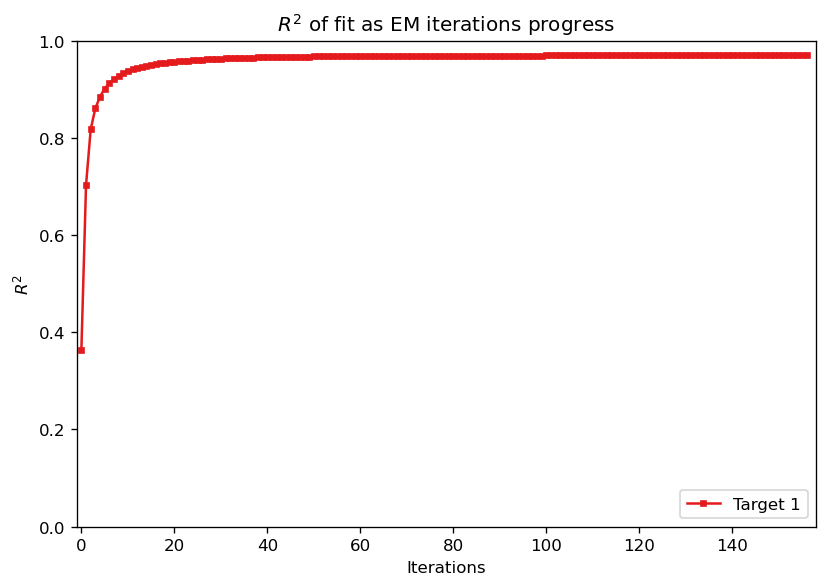

In [72]:
# Simulation control parameters
true_sigma_x, true_sigma_y = 1.0, 1.0
proportion = 0.2

# Generate synthetic data using the provided function
X_masked, Y_masked, F, P_true, Q_true = ptfa.generation.generate_data_missingatrandom(T, p, q, k, true_sigma_x, true_sigma_y,
                                                                      proportion_x=proportion, rng=rng)
X_masked = (X_masked - X_masked.mean(axis = 0)) / X_masked.std(axis = 0)
Y_masked = (Y_masked - Y_masked.mean(axis = 0)) / Y_masked.std(axis = 0)

print(np.any(X_masked.mask))

# Generate synthetic predictors for forecasting
X_pred = rng.normal(size = [h, p])

# Apply PLS regression (after imputation)
pls = PLSRegression(n_components=k)
pls.fit(X_masked.filled(), Y_masked.filled())
Y_fitted_pls_missing = pls.predict(X_masked.filled())

# Apply our PTFA EM method
ptfa_missing = ptfa.ProbabilisticTFA(n_components=k)
ptfa_missing.fit(X_masked, Y_masked, standardize=False)
Y_fitted_ptfa_missing = ptfa_missing.fitted()

# Out-of-sample prediction using both methods
Y_pred_pls_missing = pls.predict(X_pred)
Y_pred_ptfa_missing, Y_variance_ptfa_missing = ptfa_missing.predict(X_pred, compute_variance=True)

# Compute R-squared for both models and compare them
r2_pls = r2_score(Y_masked.data, Y_fitted_pls_missing, multioutput = "raw_values")
r2_ptfa_missing = r2_score(Y_masked.data, Y_fitted_ptfa_missing, multioutput = "raw_values")
r2_results = {"R^2 PLS": r2_pls, "R^2 Probabilistic PLS": r2_ptfa_missing}
print(r2_results)

# Obtain predicted confidence intervals for the prediction of Y using PTFA
Y_se_ptfa_missing = np.sqrt(np.diag(Y_variance_ptfa_missing))
CI_bounds = np.outer([-1, 1], 1.96 * Y_se_ptfa_missing)
CI_ptfa_missing = np.stack([Y_pred_ptfa_missing + CI_bounds[0], Y_pred_ptfa_missing + CI_bounds[1]])
print(CI_ptfa_missing)

# Plot path of R-squared in PTFA
max_iterations = ptfa_missing.r2_array.shape[0]
plt.figure(figsize=(7, 5), dpi=120)
plt.title("$R^2$ of fit as EM iterations progress")
for i in range(q):
    plt.plot(ptfa_missing.r2_array[:, i], "s-", color=colors(i), label=names[i], markersize=3)
plt.axis([-1, max_iterations+1, 0, 1])
plt.xlabel("Iterations")
plt.ylabel("$R^2$")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Incomplete data: Mixed-frequency
Issues of time-varying information availability, complex release schedules, and data revisions can significantly complicate the forecasting of economic phenomena in real time. This issue, generally termed as "mixed-frequency" datasets, has been given extensive attention in the economic literature. Our PTFA approach allows us to recover targeted factors that directly aim to forecast targets available at a lower frequency than the features.

Consider $X^{(m)}$ to be a $T_m \times p$ matrix of features measured at a monthly frequency, and these are used to forecast quarterly targets $Y^{(q)}$, collected into a $T_q \times q$ matrix. As the features are measured at a higher frequency than the targets, $T_q < T_m$. In any given quarter there are a total of three months, so we denote $L = 3$. Our model introduces a set of **latent** monthly targets $Y^{(m)*}$ that aggregates the high-frequency factors (denoted as $F^{(m)}$) for predicting the low-frequency targets. This situation can be represented as
$$
\begin{align*}
    X^{(m)} & = F^{(m)} P' + E_x^{(m)} \\
    Y^{*(m)} & = F^{(m)} Q' + E_y^{(m)} \\
    Y^{(q)} & = \frac{1}{L} \sum_{l=1}^{L} Y^{*(m)}
\end{align*}
$$
We provide functions that generate from this model again using independent normal distributions for $E_x^{(m)}$ and $E_y^{(m)}$.

In [73]:
# Simulation control parameters
periods = 3
low_frequency_T = int(np.ceil(T / periods))
high_frequency_T = low_frequency_T * periods
high_frequency_h = 9

# Generate synthetic data using the provided function
X, Y, F, P_true, Q_true, Y_latent = ptfa.generation.generate_data_mixedfrequency(high_frequency_T, low_frequency_T, periods, p, q, k,
                                                                 true_sigma_x, true_sigma_y, rng)
X = (X - X.mean(axis = 0)) / X.std(axis = 0)
Y = (Y - Y.mean(axis = 0)) / Y.std(axis = 0)

# Generate synthetic predictors for forecasting
X_pred = rng.normal(size = [high_frequency_h, p])

# Apply our PTFA EM method
ptfa_mixedfrequency = ptfa.ProbabilisticTFA_MixedFrequency(n_components=k)
ptfa_mixedfrequency.fit(X, Y, periods, standardize=False, track_r2=True)
Y_fitted_ptfa_mixedfrequency = ptfa_mixedfrequency.fitted()
Y_pred_ptfa_mixedfrequency, Y_variance_ptfa_mixedfrequency = ptfa_mixedfrequency.predict(X_pred, periods, compute_variance=True)

# Compute R-squared
r2_ptfa_mixedfrequency = r2_score(Y, Y_fitted_ptfa_mixedfrequency, multioutput = "raw_values")
print(r2_ptfa_mixedfrequency)

# Obtain predicted confidence intervals for the prediction of Y using PTFA
Y_se_ptfa_mixedfrequency = np.sqrt(np.diag(Y_variance_ptfa_mixedfrequency))
CI_bounds = np.outer([-1, 1], 1.96 * Y_se_ptfa_mixedfrequency)
CI_ptfa_mixedfrequency = np.stack([Y_pred_ptfa_mixedfrequency + CI_bounds[0], Y_pred_ptfa_mixedfrequency + CI_bounds[1]])
print(CI_ptfa_mixedfrequency)

[0.77663108]
[[[-1.18216614]
  [-0.92550895]
  [-0.83919426]]

 [[ 1.13529192]
  [ 1.39194911]
  [ 1.4782638 ]]]


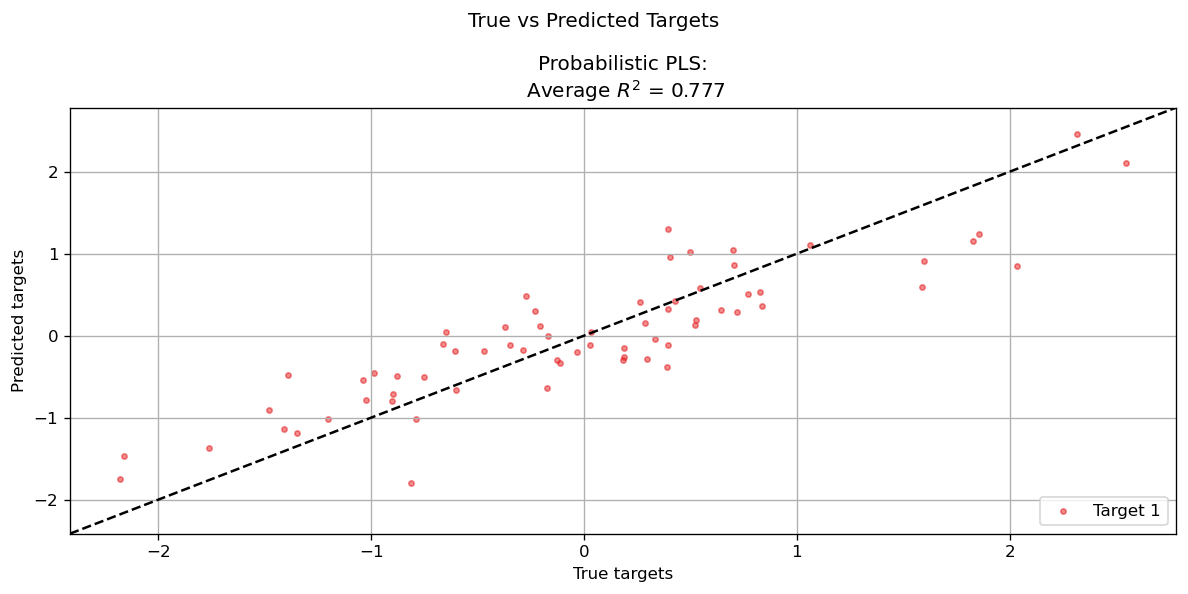

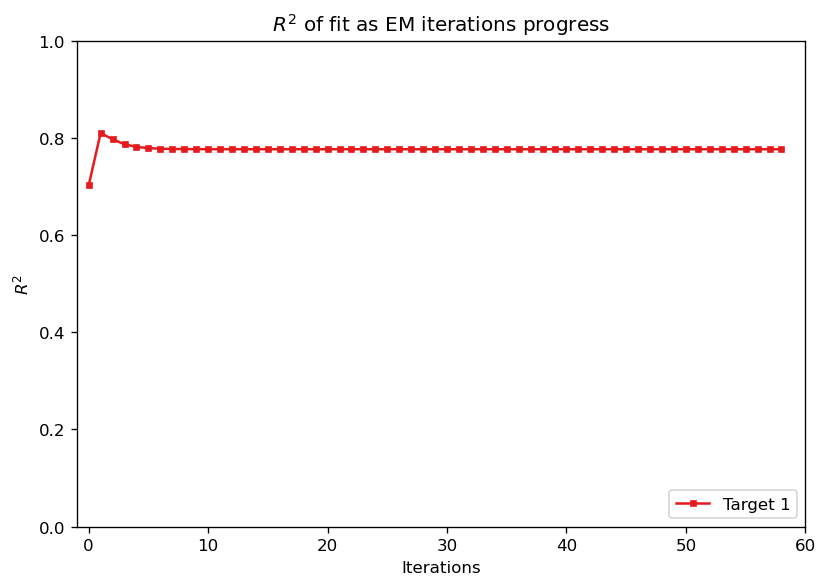

In [74]:
# Visualization of true vs. tredicted responses
all_range = variable_plot_range([Y, Y_fitted_ptfa_mixedfrequency])
axis_range = [*all_range, *all_range]
colors = plt.colormaps["Set1"]
names = ["Target " + str(i+1) for i in range(q)]
plt.figure(figsize=(10, 5), dpi=120)
plt.suptitle("True vs Predicted Targets")

# Probabilistic PLS
for i in range(q):
    plt.scatter(Y[:, i], Y_fitted_ptfa_mixedfrequency[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
plt.plot(all_range, all_range, "k--")
plt.axis(axis_range)
plt.title(f'Probabilistic PLS:\n Average $R^2$ = {np.mean(r2_ptfa_mixedfrequency):.3f}')
plt.xlabel('True targets')
plt.ylabel('Predicted targets')
plt.legend(loc="lower right")
plt.grid(True)

# Show resulting plot
plt.tight_layout()
plt.show()

# Plot path of R-squared in PTFA
max_iterations = ptfa_mixedfrequency.r2_array.shape[0]
plt.figure(figsize=(7, 5), dpi=120)
plt.title("$R^2$ of fit as EM iterations progress")
for i in range(q):
    plt.plot(ptfa_mixedfrequency.r2_array[:, i], "s-", color=colors(i), label=names[i], markersize=3)
plt.axis([-1, max_iterations+1, 0, 1])
plt.xlabel("Iterations")
plt.ylabel("$R^2$")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Stochastic volatility
In economic applications, it is standard to allow for the volatility of both feature and target variables involved to experience persistence across time. To this end, we can allow for $E_{X, t} \sim \text{Normal}(0_p, \sigma_{x, t}^2 I_p)$ and $E_{Y, t} \sim \text{Normal}(0_q, \sigma_{y, t}^2 I_p)$ where $I_n$ is an identity matrix of order $n$. We provide functions that generate $X$ and $Y$ assuming that initial scales $\sigma_{x, 0}^2$ and $\sigma_{y, 0}^2$ are updated according to the exponentially weighted moving average (EWMA) process:
$$
\begin{align*}
    \sigma_{x, t}^2 & = \lambda_x \sigma_{x, t-1}^2 + (1 - \lambda_x) \eta_{x, t}^2 \\
    \sigma_{y, t}^2 & = \lambda_y \sigma_{y, t-1}^2 + (1 - \lambda_y) \eta_{y, t}^2
\end{align*}
$$
where $\eta_{x, t} \sim \text{Normal}(0, \sigma_{x, 0}^2)$ and $\eta_{y, t} \sim \text{Normal}(0, \sigma_{y, 0}^2)$ are independent white noise processes and $\lambda_x$ and $\lambda_y$ are smoothing parameters.

In [75]:
# Simulation parameters
sigma2_x0, sigma2_y0 = 0.5, 0.5  # Initial variances (also the variance of the moving average component in EWMA generation)
lambda_x, lambda_y = 0.94, 0.94  # EWMA smoothing parameters for X and Y

# Generate synthetic data
X, Y, _, P_true, Q_true, true_sigma2_x, true_sigma2_y = ptfa.generation.generate_data_stochasticvolatility(T, p, q, k, sigma2_x0, sigma2_y0, lambda_x, lambda_y, rng)
X = (X - X.mean(axis = 0)) / X.std(axis = 0)
Y = (Y - Y.mean(axis = 0)) / Y.std(axis = 0)

# Apply PLS regression
pls = PLSRegression(n_components=k)
pls.fit(X, Y)
Y_fitted_pls = pls.predict(X)

# Create and train the ProbabilisticTFA model with stochastic volatility
ptfa_sv_model = ptfa.ProbabilisticTFA_StochasticVolatility(n_components=k)
ptfa_sv_model.fit(X, Y, ewma_lambda_x=lambda_x,ewma_lambda_y=lambda_y, standardize=False)
Y_fitted_ptfa_sv = ptfa_sv_model.fitted()

# Create and trend the model without taking into account SV for comparison
ptfa_model = ptfa.ProbabilisticTFA(n_components=k)
ptfa_model.fit(X, Y, standardize=False)
Y_fitted_ptfa_simple = ptfa_model.fitted()

# Out-of-sample prediction using all methods
Y_pred_pls_sv = pls.predict(X_pred)
Y_pred_ptfa_sv, Y_variance_ptfa_sv = ptfa_sv_model.predict(X_pred, compute_variance=True)

# Compute R-squared for all models and compare them
r2_pls = r2_score(Y, Y_fitted_pls, multioutput = "raw_values")
r2_ptfa_sv = r2_score(Y, Y_fitted_ptfa_sv, multioutput = "raw_values")
r2_ptfa_simple = r2_score(Y, Y_fitted_ptfa_simple, multioutput = "raw_values")
r2_results = {"R^2 PLS": r2_pls, "R^2 PTFA SV": r2_ptfa_sv, "R^2 PTFA Simple": r2_ptfa_simple}
print(r2_results)

# Obtain predicted confidence intervals for the prediction of Y using PTFA
Y_se_ptfa_sv = np.sqrt(np.diag(Y_variance_ptfa_sv))
print(Y_se_ptfa_sv)
CI_bounds = np.outer([-1, 1], 1.96 * Y_se_ptfa_sv)
CI_ptfa_sv = np.stack([Y_pred_ptfa_sv + CI_bounds[0], Y_pred_ptfa_sv + CI_bounds[1]])
print(CI_ptfa_sv)


{'R^2 PLS': array([0.70755959]), 'R^2 PTFA SV': array([0.79134031]), 'R^2 PTFA Simple': array([0.83261856])}
[0.60122133]
[[[-1.42145017]
  [-1.90916389]
  [-1.64348359]
  [-0.82564404]
  [-0.50302425]
  [-1.57159328]
  [-1.57006775]
  [-1.38431701]
  [-1.3007494 ]]

 [[ 0.93533745]
  [ 0.44762373]
  [ 0.71330403]
  [ 1.53114357]
  [ 1.85376337]
  [ 0.78519434]
  [ 0.78671987]
  [ 0.97247061]
  [ 1.05603821]]]


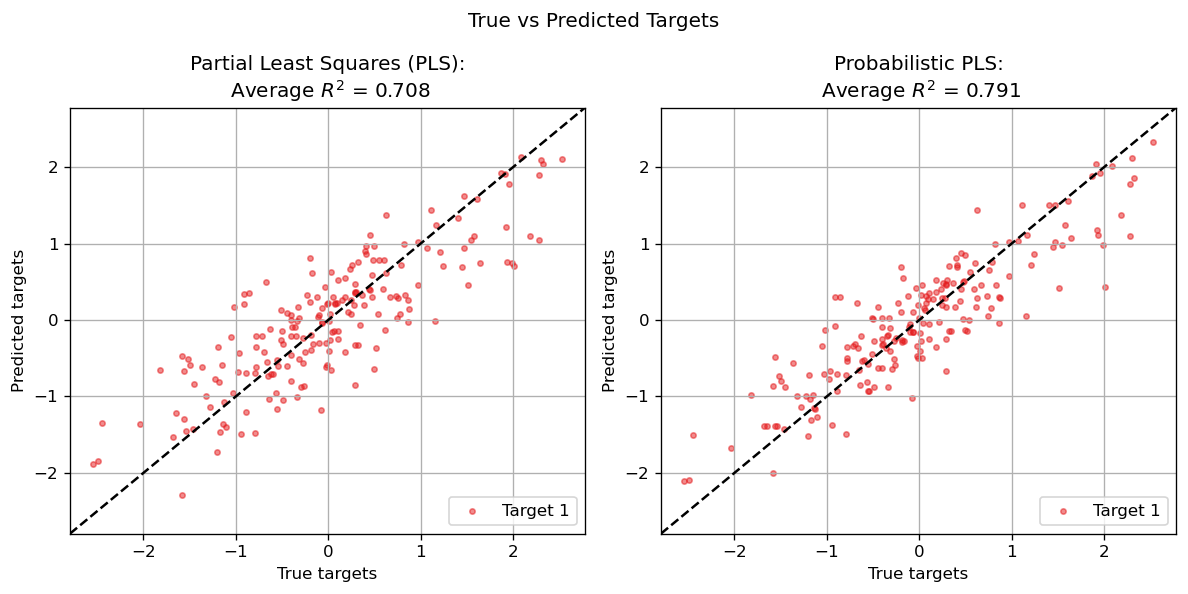

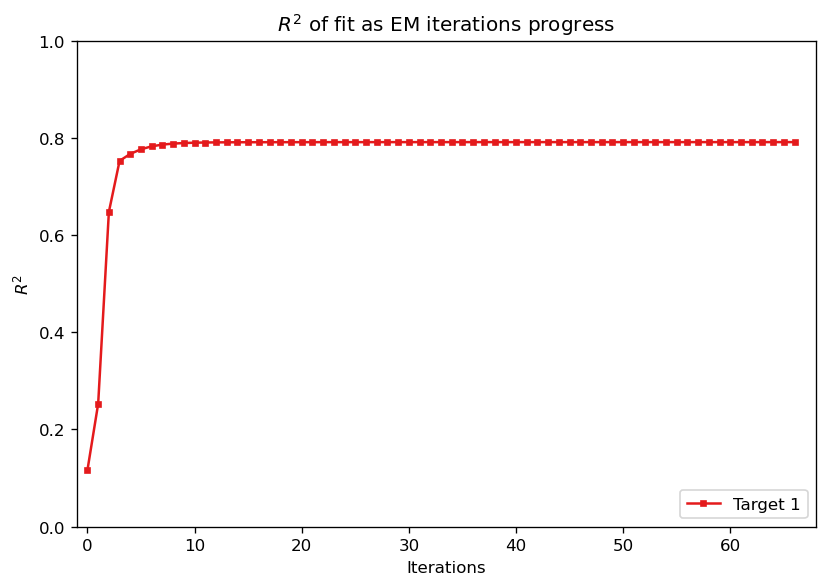

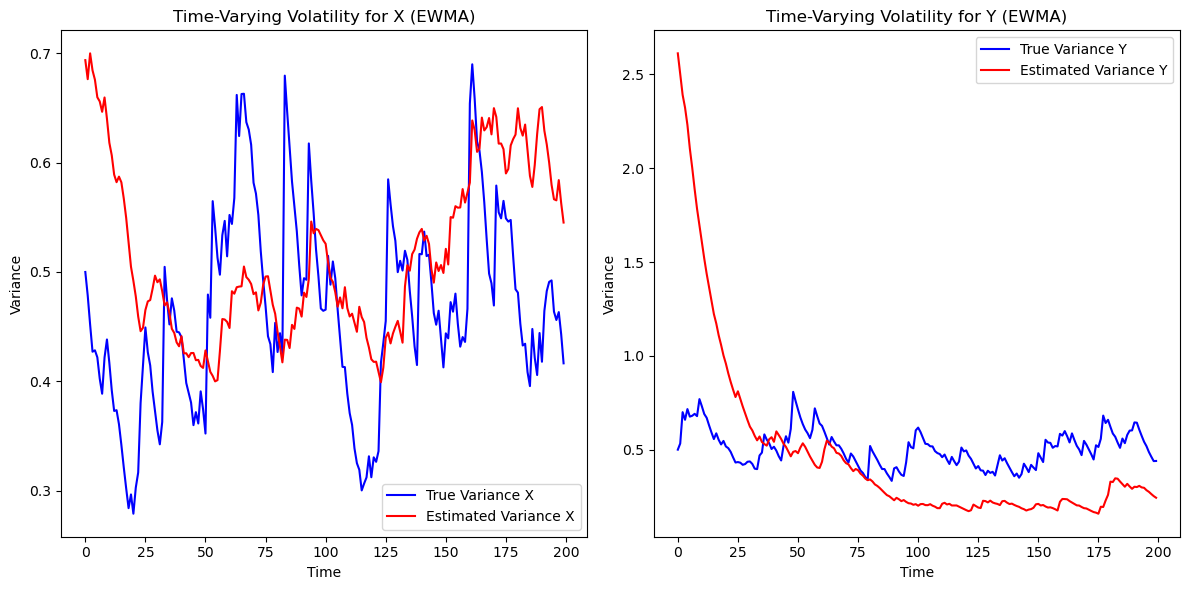

In [76]:
# Visualize comparison between methods
all_range = variable_plot_range([Y, Y_fitted_pls, Y_fitted_ptfa_sv])
axis_range = [*all_range, *all_range]
colors = plt.colormaps["Set1"]
names = ["Target " + str(i+1) for i in range(q)]

# Visualization of true vs. tredicted responses
plt.figure(figsize=(10, 5), dpi=120)
plt.suptitle("True vs Predicted Targets")

# PLS regression
plt.subplot(1, 2, 1)
for i in range(q):
    plt.scatter(Y[:, i], Y_fitted_pls[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
plt.plot(all_range, all_range, "k--")
plt.axis(axis_range)
plt.title(f'Partial Least Squares (PLS):\n Average $R^2$ = {np.mean(r2_pls):.3f}')
plt.xlabel('True targets')
plt.ylabel('Predicted targets')
plt.legend(loc="lower right")
plt.grid(True)

# Probabilistic PLS with Stochastic Volatility
plt.subplot(1, 2, 2)
for i in range(q):
    plt.scatter(Y[:, i], Y_fitted_ptfa_sv[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
plt.plot(all_range, all_range, "k--")
plt.axis(axis_range)
plt.title(f'Probabilistic PLS:\n Average $R^2$ = {np.mean(r2_ptfa_sv):.3f}')
plt.xlabel('True targets')
plt.ylabel('Predicted targets')
plt.legend(loc="lower right")
plt.grid(True)

# Show resulting plot
plt.tight_layout()
plt.show()

# Plot path of R-squared in PTFA
max_iterations = ptfa_sv_model.r2_array.shape[0]
plt.figure(figsize=(7, 5), dpi=120)
plt.title("$R^2$ of fit as EM iterations progress")
for i in range(q):
    plt.plot(ptfa_sv_model.r2_array[:, i], "s-", color=colors(i), label=names[i], markersize=3)
plt.axis([-1, max_iterations+1, 0, 1])
plt.xlabel("Iterations")
plt.ylabel("$R^2$")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Fetch the estimated volatilities
estimated_sigma2_x = ptfa_sv_model.sigma2_x  # Estimated time-varying volatility for X (EWMA-based)
estimated_sigma2_y = ptfa_sv_model.sigma2_y  # Estimated time-varying volatility for Y (EWMA-based)

# Plot estimated vs true volatilities
plt.figure(figsize=(12, 6))

# Plot for X
plt.subplot(1, 2, 1)
plt.plot(true_sigma2_x, label="True Variance X", color="blue")
plt.plot(estimated_sigma2_x, label="Estimated Variance X", color="red")
plt.title("Time-Varying Volatility for X (EWMA)")
plt.xlabel("Time")
plt.ylabel("Variance")
plt.legend()

# Plot for Y
plt.subplot(1, 2, 2)
plt.plot(true_sigma2_y, label="True Variance Y", color="blue")
plt.plot(estimated_sigma2_y, label="Estimated Variance Y", color="red")
plt.title("Time-Varying Volatility for Y (EWMA)")
plt.xlabel("Time")
plt.ylabel("Variance")
plt.legend()

plt.tight_layout()
plt.show()

## Factor Dynamics
A final extension that is of particular interest to economic data is to allow for dynamic relationships and persistence in the factors. As the recovered components are usually interpreted as fundamental drivers of business cycles and co-movements between economic series, it is natural to allow for these fundamentals to exhibit persistence across time. To this end, at each time $t \in \{1, \ldots, T\}$, we augment our initial model equations to include a dynamic equation for the factors:
$$
\begin{align*}
    x_t & = P f_t + e_{x, t} \\
    y_t & = Q f_t + e_{y, t} \\
    f_t & = A f_{t-1} + v_t
\end{align*}
$$
We include the coefficients $A$ ($k \times k$ matrix) and initial conditions $f_0$ ($k$-dimensional vector) as additional parameters to estimate in our EM algorithm. We continue to assume $e_{x, t}$ and $e_{y, t}$ to be uncorrelated at each point in time with a fixed variance $\sigma_{x}^2$ and $\sigma_{y}^2$, respectively. Additionally, these disturbances are also assumed uncorrelated to the white noise process $v_t$ that has mean $0$ and variance $V_F$. Note that this variance is the same as the prior variance before, as this quantity is not identified from the data (unless additional identification restrictions are imposed in the system).

In [77]:
# Simulation control parameters
true_sigma_x, true_sigma_y = 1.0, 1.0
f0_true = rng.normal(size = k)
def stable_coefficients(k, rng):
    M = rng.lognormal(size=(k,k))               # Draw a random matrix with positive entries
    rho = np.max(np.abs(np.linalg.eigvals(M)))  # Compute spectral radius
    return M / (1 + rho)                        # Scale to ensure stability (all eigenvalues < 1 in modulus)
A_true = stable_coefficients(k, rng)

# Generate synthetic data using the provided function
X, Y, F, P_true, Q_true = ptfa.generation.generate_data_dynamicfactors(T, p, q, k, true_sigma_x, true_sigma_y, A_true, f0_true, rng)
X = (X - X.mean(axis = 0)) / X.std(axis = 0)
Y = (Y - Y.mean(axis = 0)) / Y.std(axis = 0)

# Generate synthetic predictors for forecasting
X_pred = rng.normal(size = [h, p])

# Apply PLS regression
pls = PLSRegression(n_components=k)
pls.fit(X, Y)
Y_fitted_pls_dynamic = pls.predict(X)

# Apply our PTFA EM method with AR(1) factor dynamics
ptfa_dynamic = ptfa.ProbabilisticTFA_DynamicFactors(n_components=k)
ptfa_dynamic.fit(X, Y, standardize=False)
Y_fitted_ptfa_dynamic = ptfa_dynamic.fitted()

# Out-of-sample prediction using both methods
Y_pred_pls_dynamic = pls.predict(X_pred)
Y_pred_ptfa_dynamic, Y_variance_ptfa_dynamic = ptfa_dynamic.predict(X_pred, compute_variance=True)
print(Y_pred_ptfa_dynamic)
print(Y_variance_ptfa_dynamic)

# Compute R-squared for both models and compare them
r2_pls_dynamic = r2_score(Y, Y_fitted_pls_dynamic, multioutput = "raw_values")
r2_ptfa_dynamic = r2_score(Y, Y_fitted_ptfa_dynamic, multioutput = "raw_values")
r2_results = {"R^2 PLS": r2_pls_dynamic, "R^2 Probabilistic PLS": r2_ptfa_dynamic}
print(r2_results)

# Obtain predicted confidence intervals for the prediction of Y using PTFA
Y_se_ptfa_dynamic = np.vstack([np.sqrt(np.diag(Y_variance_ptfa_dynamic[j])) for j in range(h)])
CI_ptfa_dynamic = np.stack([Y_pred_ptfa_dynamic - 1.96 * Y_se_ptfa_dynamic, Y_pred_ptfa_dynamic + 1.96 * Y_se_ptfa_dynamic])
print(CI_ptfa_dynamic)

[[0.13404261]]
[[[0.2144164]]]
{'R^2 PLS': array([0.78742111]), 'R^2 Probabilistic PLS': array([0.95724731])}
[[[-0.77353771]]

 [[ 1.04162293]]]


In [78]:
# # Line-by-line testing of PTFA DFM prediction with small number of new variables
# from scipy import sparse
# from scipy import linalg
# X = X_pred.copy()
# Tk = ptfa_dynamic.factors.shape[0] * k
# P_scaled =  ptfa_dynamic.P / ptfa_dynamic.sigma2_x
# V_times_A = ptfa_dynamic.V_prior_inv @ ptfa_dynamic.A
# A_V_A = ptfa_dynamic.A.T @ V_times_A
# Omega_inv_X = ptfa_dynamic.V_prior_inv + P_scaled.T @ ptfa_dynamic.P

# # Recover Omega_{T, T} and M_T final diagonal block for updating one-step ahead forecast
# Omega_TT = ptfa_dynamic.Omega[:k, range(Tk-k, Tk)]
# offsets = range(0, -k, -1)
# Omega_TT = sparse.diags(Omega_TT, offsets, shape=(k, k)).toarray()
# Omega_correction = linalg.inv(ptfa_dynamic.A @ Omega_TT @ ptfa_dynamic.A.T + ptfa_dynamic.V_prior)
# M_T = ptfa_dynamic.factors[-1]
# print(Omega_TT)
# print(Omega_correction)
# print(M_T)

# # Save posterior precision in sparse representation as intermediate
# sparse_identity = sparse.eye(h, format='lil')
# main_diagonal = sparse.kron(sparse_identity, Omega_inv_X)
# print(main_diagonal.todense())
# lower_diagonal = sparse.kron(sparse.eye(h, k=-1, format='csc'), -V_times_A)
# print(lower_diagonal.todense())
# sparse_identity[-1, -1] = 0.0   # Remove last element to create last block
# diagonal_correction = sparse.kron(sparse_identity, A_V_A)
# print(diagonal_correction.todense())
# sparse_identity[1:, 1:] = 0.0   # Keep only first block for final correction
# first_block_correction = sparse.kron(sparse_identity, Omega_correction - ptfa_dynamic.V_prior_inv)
# print(first_block_correction.todense())
# Omega_inv_sparse = main_diagonal + lower_diagonal + diagonal_correction + first_block_correction
# print(Omega_inv_sparse.todense())


# # Save posterior precision to a symmetric banded matrix and compute its Cholesky decomposition
# # (hk x hk) -> (2k x hk), only storing the 2k lower diagonal bands
# Omega_inv_cholesky = np.zeros([2 * k, h * k])
# min_dimension = min(h, 2)
# for diagonal in range(min_dimension * k):
#     print(diagonal)
#     print(Omega_inv_sparse.diagonal(-diagonal))
#     Omega_inv_cholesky[diagonal, :(h * k - diagonal)] = Omega_inv_sparse.diagonal(-diagonal)
# print(Omega_inv_cholesky)
# Omega_inv_cholesky = linalg.cholesky_banded(Omega_inv_cholesky, overwrite_ab=True, lower=True)
# print(Omega_inv_cholesky)
# asd = np.diag(Omega_inv_cholesky[0]) + np.diag(Omega_inv_cholesky[1, :1], -1)
# print(asd @ asd.T)
        
# # Compute predicted factors using banded matrix solver
# F_predicted = np.ravel(X @ P_scaled)
# F_predicted[:k] += Omega_correction @ ptfa_dynamic.A @ M_T
# print(F_predicted)
# F_predicted = linalg.cho_solve_banded((Omega_inv_cholesky, True), b = F_predicted, overwrite_b=True).reshape([h, k])
# print(F_predicted)

# # PTFA out-of-sample prediction:
# Y_hat = F_predicted @ ptfa_dynamic.Q.T

# # Compute variance of predicted factors using banded matrix inversion
# Omega_X_banded = ptfa_dynamic.bands_cholesky(Omega_inv_cholesky, k - 1)

# # Compute variance of each prediction (no covariance between predictions)
# q = ptfa_dynamic.Q.shape[0]
# Y_hat_variance = np.zeros([h, q, q])
# for t in range(h):
#     # Extract Omega_{t, t} block from banded representation
#     Omega_X_tt = Omega_X_banded[:k, range(t * k, (t + 1) * k)]
#     Omega_X_tt = sparse.diags(Omega_X_tt, offsets, shape=(k, k)).toarray()
#     Y_hat_variance[t] = ptfa_dynamic.sigma2_y * np.eye(q) + ptfa_dynamic.Q @ Omega_X_tt @ ptfa_dynamic.Q.T

# print(Y_hat)
# print(Y_hat_variance)

In [79]:
# # Standardization test
# T, p, q, k, h = 200, 10, 3, 2, 5
# true_sigma_x, true_sigma_y = 1.0, 1.0
# seed_value = 12345
# rng = np.random.default_rng(seed_value)

# # Generate synthetic data using the provided function
# X, Y, F, P_true, Q_true = ptfa.generation.generate_data_simple(T, p, q, k, true_sigma_x, true_sigma_y, rng)
# X_mean = rng.lognormal(mean=5, sigma=2, size=p)
# X_std = rng.lognormal(mean=2, sigma=0.1, size=p)
# Y_mean = rng.lognormal(mean=5, sigma=2, size=q)
# Y_std = rng.lognormal(mean=2, sigma=0.1, size=q)
# X = X * X_std + X_mean
# Y = Y * Y_std + Y_mean
# X_pred = rng.normal(size=[h, p], loc=X_mean, scale=X_std)
# # X = (X - X.mean(axis = 0)) / X.std(axis = 0)
# # Y = (Y - Y.mean(axis = 0)) / Y.std(axis = 0)

# print(X_mean)
# print(X_std)
# print(Y_mean)
# print(Y_std)
# print(X.mean(axis=0))
# print(X.std(axis=0))
# print(Y.mean(axis=0))
# print(Y.std(axis=0))

# # Apply PLS regression
# pls = PLSRegression(n_components=k)
# pls.fit(X, Y)
# Y_fitted_pls_simple = pls.predict(X)

# # Apply our PTFA EM method
# ptfa_simple = ptfa.ProbabilisticTFA(n_components=k)
# ptfa_simple.fit(X, Y, standardize=False)
# Y_fitted_ptfa_simple = ptfa_simple.fitted()

# # Out-of-sample prediction using both methods
# Y_pred_pls_simple = pls.predict(X_pred)
# Y_pred_ptfa_simple, Y_variance_ptfa_simple = ptfa_simple.predict(X_pred, standardize = False, compute_variance = True)

# # All predictions
# print(X.mean(axis=0))
# print(Y.mean(axis=0))
# print(Y_fitted_pls_simple.mean(axis=0))
# print(Y_fitted_ptfa_simple.mean(axis=0))
# print(Y_pred_pls_simple.mean(axis=0))
# print(Y_pred_ptfa_simple.mean(axis=0))
# print(Y_variance_ptfa_simple)

# # All parameters
# print(ptfa_simple.P)
# print(ptfa_simple.Q)
# print(ptfa_simple.sigma2_x)
# print(ptfa_simple.sigma2_y)
# print(ptfa_simple.factors.mean(axis=0))

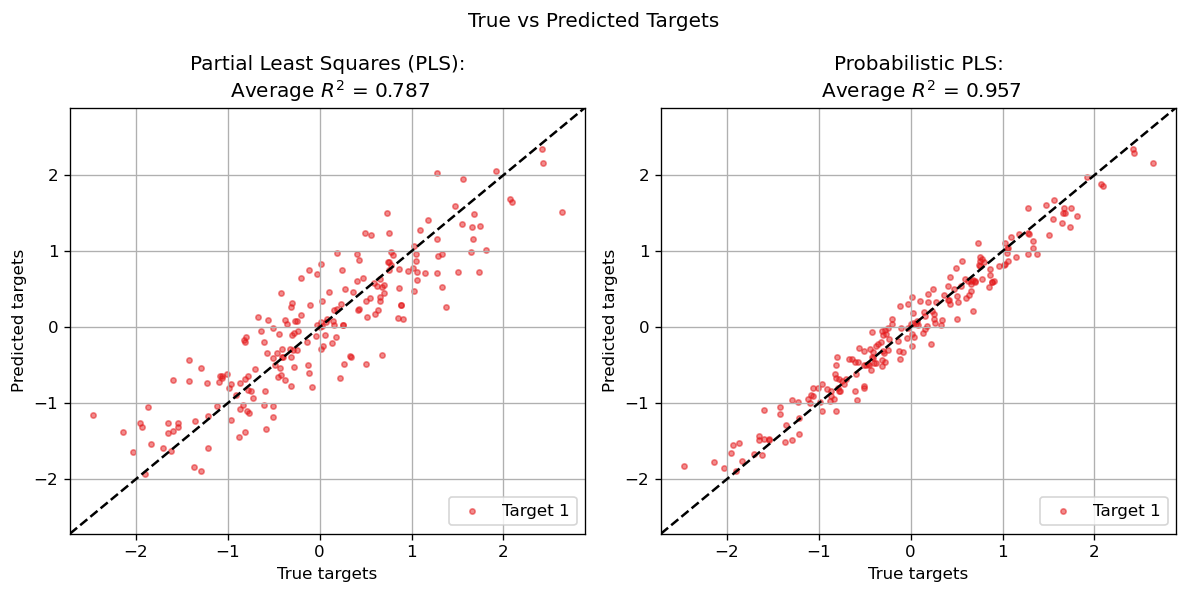

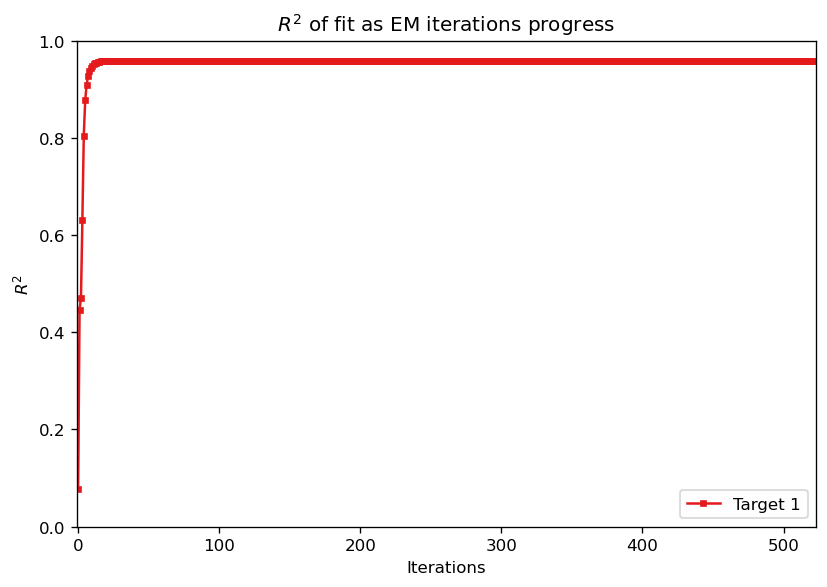

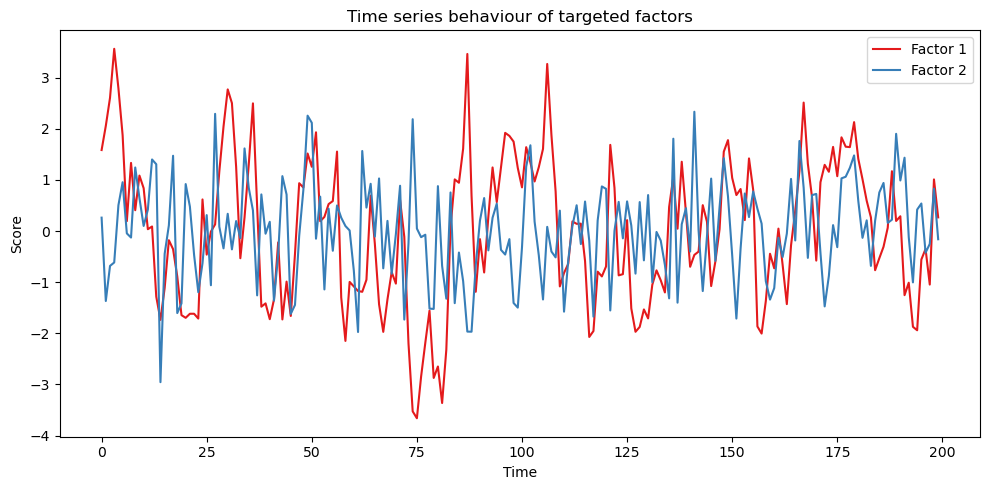

In [80]:
# Visualize comparison between methods
all_range = variable_plot_range([Y, Y_fitted_pls_dynamic, Y_fitted_ptfa_dynamic])
axis_range = [*all_range, *all_range]
colors = plt.colormaps["Set1"]
names = ["Target " + str(i+1) for i in range(q)]

# Visualization of true vs. tredicted responses
plt.figure(figsize=(10, 5), dpi=120)
plt.suptitle("True vs Predicted Targets")

# PLS regression
plt.subplot(1, 2, 1)
for i in range(q):
    plt.scatter(Y[:, i], Y_fitted_pls_dynamic[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
plt.plot(all_range, all_range, "k--")
plt.axis(axis_range)
plt.title(f'Partial Least Squares (PLS):\n Average $R^2$ = {np.mean(r2_pls_dynamic):.3f}')
plt.xlabel('True targets')
plt.ylabel('Predicted targets')
plt.legend(loc="lower right")
plt.grid(True)

# Probabilistic PLS (Without standardization)
plt.subplot(1, 2, 2)
for i in range(q):
    plt.scatter(Y[:, i], Y_fitted_ptfa_dynamic[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
plt.plot(all_range, all_range, "k--")
plt.axis(axis_range)
plt.title(f'Probabilistic PLS:\n Average $R^2$ = {np.mean(r2_ptfa_dynamic):.3f}')
plt.xlabel('True targets')
plt.ylabel('Predicted targets')
plt.legend(loc="lower right")
plt.grid(True)

# Show resulting plot
plt.tight_layout()
plt.show()

# Plot path of R-squared in PTFA
max_iterations = ptfa_dynamic.r2_array.shape[0]
plt.figure(figsize=(7, 5), dpi=120)
plt.title("$R^2$ of fit as EM iterations progress")
for i in range(q):
    plt.plot(ptfa_dynamic.r2_array[:, i], "s-", color=colors(i), label=names[i], markersize=3)
plt.axis([-1, max_iterations+1, 0, 1])
plt.xlabel("Iterations")
plt.ylabel("$R^2$")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Time series plots of recovered factors
factor_names = ["Factor " + str(j+1) for j in range(k)]
recovered_factors = ptfa_dynamic.factors
plt.figure(figsize=(10, 5))
for j in range(k):
    plt.plot(recovered_factors[:, j], color=colors(j), label=factor_names[j])
plt.title("Time series behaviour of targeted factors")
plt.xlabel("Time")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()